# Research Motivation:

> Exploring the concept of combining GNNs and RL and their applicability within fitness domains, particularly user workouts, to predict optimalness.

The dataset comprises approximately 6 weeks of real, personal training logs, augmented with simulated sessions that extend realistic progression trends to provide sufficient temporal depth for model training.

## Section 1: Environment Setup & Imports
This section installs required libraries (if needed) and
imports all necessary Python packages for:
- Data handling (pandas, numpy)
- Graph construction (networkx)
- Graph Neural Network modeling (PyTorch Geometric)
- Visualization and evaluation

In [48]:
# Installing PyTorch Geometric (only run once per session)
!pip install -q torch torchvision torchaudio
!pip install -q torch-geometric networkx pandas matplotlib scikit-learn

In [49]:
import torch, torch_geometric
print("Torch:", torch.__version__)
print("PyTorch Geometric:", torch_geometric.__version__)

Torch: 2.9.0+cu126
PyTorch Geometric: 2.7.0


## Section 2: Library Imports
Import standard Python libraries for data loading, graph
construction, and neural network modeling.

In [50]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv, SAGEConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Section 3: Device Configuration
Automatically detects GPU (if available in Colab)
and sets up PyTorch to use it for faster training.

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Section 4: Data Loading & Preprocessing
1.  Loads raw workout data exported from Google Sheets.
2.  Compute derived metrics (e.g., total training volume)
3. Applies rule-based progressive overload logic to create
next-session targets for weight, reps, and rest time.
4. Normalize numeric inputs for stability.
5. Separate features and targets for the GNN.



### 4.1 Load Data from Google Sheets Export

In [52]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRBmQVSoy1-DOoT-FZAFjBD7eMLva3_6qXRHsuHs8d-XJW7WXCMckbuXSd_wIpDyb6qwVI1g0giOfBK/pub?gid=1249841840&single=true&output=csv"

# Load directly from the published CSV URL
df = pd.read_csv(url)

print("Data loaded successfully from Google Sheets!")
print(f"Rows: {len(df)} | Columns: {list(df.columns)}")
display(df.head())

Data loaded successfully from Google Sheets!
Rows: 144 | Columns: ['week', 'date', 'day_type', 'exercise', 'exercise_type', 'sets', 'reps', 'weight', 'rest_time', 'intensity', 'fatigue', 'RIR', 'days_since_last', 'volume', 'y_next_weight', 'y_next_reps', 'y_next_rest']


,week,date,day_type,exercise,exercise_type,sets,reps,weight,rest_time,intensity,fatigue,RIR,days_since_last,volume,y_next_weight,y_next_reps,y_next_rest
0,1,2025-10-01,Pull,Pull-ups,bodyweight,3,9,150.0,60,8,9,3,3,NaN,NaN,NaN,NaN
1,1,2025-10-01,Pull,Barbell Curls,compound,3,10,50.0,105,8,9,2,3,NaN,NaN,NaN,NaN
2,1,2025-10-01,Pull,Lat Pulldowns,compound,3,13,130.0,105,9,9,2,3,NaN,NaN,NaN,NaN
3,1,2025-10-01,Pull,Hammer Curls,isolation,3,10,25.0,120,7,7,1,3,NaN,NaN,NaN,NaN
4,1,2025-10-01,Pull,Seated Rows,compound,3,10,130.0,75,8,7,1,3,NaN,NaN,NaN,NaN


### 4.2 Feature Engineering (Compute Derived Metrics)

In [53]:
# Compute total training volume (sets × reps × weight)
df["volume"] = df["sets"] * df["reps"] * df["weight"]

# PLOS ONE: Clemente et al. inspired training load metrics
df["training_load"] = df["volume"] * df["intensity"]  # Total session load
df["weekly_load"] = df.groupby("week")["training_load"].transform("sum")
df["training_monotony"] = df["training_load"] / df.groupby("week")["training_load"].transform("std").replace(0, 1)
df["strain"] = df["weekly_load"] * df["training_monotony"]

# Define numeric features for the model
numeric_features = [
    "sets", "reps", "weight", "rest_time",
    "intensity", "fatigue", "days_since_last", "volume"
]

numeric_features += ["training_load", "training_monotony", "strain"]

# Ensure correct numeric types
df[numeric_features] = df[numeric_features].astype(float)

print("Volume computed and numeric features confirmed.")
display(df.head())

Volume computed and numeric features confirmed.


,week,date,day_type,exercise,exercise_type,sets,reps,weight,rest_time,intensity,...,RIR,days_since_last,volume,y_next_weight,y_next_reps,y_next_rest,training_load,weekly_load,training_monotony,strain
0,1,2025-10-01,Pull,Pull-ups,bodyweight,3.0,9.0,150.0,60.0,8.0,...,3,3.0,4050.0,NaN,NaN,NaN,32400.0,491572.5,2.732683,1.343312e+06
1,1,2025-10-01,Pull,Barbell Curls,compound,3.0,10.0,50.0,105.0,8.0,...,2,3.0,1500.0,NaN,NaN,NaN,12000.0,491572.5,1.012105,4.975230e+05
2,1,2025-10-01,Pull,Lat Pulldowns,compound,3.0,13.0,130.0,105.0,9.0,...,2,3.0,5070.0,NaN,NaN,NaN,45630.0,491572.5,3.848529,1.891831e+06
3,1,2025-10-01,Pull,Hammer Curls,isolation,3.0,10.0,25.0,120.0,7.0,...,1,3.0,750.0,NaN,NaN,NaN,5250.0,491572.5,0.442796,2.176663e+05
4,1,2025-10-01,Pull,Seated Rows,compound,3.0,10.0,130.0,75.0,8.0,...,1,3.0,3900.0,NaN,NaN,NaN,31200.0,491572.5,2.631473,1.293560e+06


### 4.3 Progressive Overload Target Computation (subject to change)

In [54]:
# Add this new helper above compute_overload_targets()
def load_to_volume_equivalence(delta_weight, weight):
    """
    Converts a % load increase into equivalent rep/rest adjustment.
    Approximation: +2.5% load ≈ +1 rep or -10s rest
    """
    percent_change = delta_weight / weight if weight > 0 else 0
    extra_reps = int(round(percent_change * 40))
    rest_reduction = int(round(percent_change * 400))
    return extra_reps, rest_reduction


def compute_overload_targets(row):
    # Defaults
    delta_w, delta_r, delta_rest = 0, 0, 0

    # Adjust logic based on exercise type
    if row["exercise_type"] == "compound":
        if row["fatigue"] <= 6 and row["RIR"] >= 2:
            delta_w = row["weight"] * 0.025
        elif 6 < row["fatigue"] <= 8 and 1 <= row["RIR"] < 2:
            delta_w = row["weight"] * 0.015
        elif row["fatigue"] > 8 or row["RIR"] < 1:
            delta_w = -row["weight"] * 0.03
            delta_rest = +20

    elif row["exercise_type"] == "bodyweight":
        if row["fatigue"] <= 6 and row["RIR"] >= 2:
            # translate +2.5% load into more reps or less rest
            reps_add, rest_red = load_to_volume_equivalence(row["weight"] * 0.025, row["weight"])
            delta_r = +reps_add
            delta_rest = -rest_red
        elif row["fatigue"] > 8:
            delta_r = -1
            delta_rest = +20

    elif row["exercise_type"] == "isolation":
        if row["fatigue"] <= 7 and row["RIR"] >= 1:
            delta_w = row["weight"] * 0.015
        elif row["fatigue"] > 8:
            delta_rest = +15

    # Week-based deloading every 5th week
    if row["week"] % 5 == 0:
        delta_w = -row["weight"] * 0.05
        delta_rest = +30

    return pd.Series({
        "y_next_weight": max(0, row["weight"] + delta_w),
        "y_next_reps": max(1, row["reps"] + delta_r),
        "y_next_rest": max(60, row["rest_time"] + delta_rest)
    })

### 4.3b Apply Progressive Overload Function

In [55]:
#  Generates next-session targets (weight, reps, rest)
#  for each exercise entry based on fatigue, RIR, etc.

target_cols = ["y_next_weight", "y_next_reps", "y_next_rest"]

df[target_cols] = df.apply(compute_overload_targets, axis=1)
print("Next-session targets computed successfully.")
display(df[target_cols].head())

# After: df[target_cols] = df.apply(compute_overload_targets, axis=1)

# Reorder columns so targets appear last
target_cols = ["y_next_weight", "y_next_reps", "y_next_rest"]

df = df[[c for c in df.columns if c not in target_cols] + target_cols]

print("Columns reordered successfully.")
display(df.head(15))

Next-session targets computed successfully.


,y_next_weight,y_next_reps,y_next_rest
0,150.000,8.0,80.0
1,48.500,10.0,125.0
2,126.100,13.0,125.0
3,25.375,10.0,120.0
4,131.950,10.0,75.0


Columns reordered successfully.


,week,date,day_type,exercise,exercise_type,sets,reps,weight,rest_time,intensity,...,RIR,days_since_last,volume,training_load,weekly_load,training_monotony,strain,y_next_weight,y_next_reps,y_next_rest
0,1,2025-10-01,Pull,Pull-ups,bodyweight,3.0,9.0,150.0,60.0,8.0,...,3,3.0,4050.0,32400.0,491572.5,2.732683,1.343312e+06,150.0000,8.0,80.0
1,1,2025-10-01,Pull,Barbell Curls,compound,3.0,10.0,50.0,105.0,8.0,...,2,3.0,1500.0,12000.0,491572.5,1.012105,4.975230e+05,48.5000,10.0,125.0
2,1,2025-10-01,Pull,Lat Pulldowns,compound,3.0,13.0,130.0,105.0,9.0,...,2,3.0,5070.0,45630.0,491572.5,3.848529,1.891831e+06,126.1000,13.0,125.0
3,1,2025-10-01,Pull,Hammer Curls,isolation,3.0,10.0,25.0,120.0,7.0,...,1,3.0,750.0,5250.0,491572.5,0.442796,2.176663e+05,25.3750,10.0,120.0
4,1,2025-10-01,Pull,Seated Rows,compound,3.0,10.0,130.0,75.0,8.0,...,1,3.0,3900.0,31200.0,491572.5,2.631473,1.293560e+06,131.9500,10.0,75.0
5,1,2025-10-01,Pull,Seated Curls,isolation,3.0,11.0,80.0,60.0,8.0,...,3,3.0,2640.0,21120.0,491572.5,1.781305,8.756404e+05,80.0000,11.0,60.0
6,1,2025-10-02,Push,Tricep Extensions,isolation,3.0,11.0,25.0,105.0,8.0,...,1,2.0,825.0,6600.0,491572.5,0.556658,2.736376e+05,25.3750,11.0,105.0
7,1,2025-10-02,Push,Incline Bench Press,compound,2.0,9.0,225.0,120.0,7.0,...,3,2.0,4050.0,28350.0,491572.5,2.391098,1.175398e+06,225.0000,9.0,120.0
8,1,2025-10-02,Push,Lateral Raises,isolation,3.0,12.0,30.0,90.0,8.0,...,2,2.0,1080.0,8640.0,491572.5,0.728716,3.582165e+05,30.0000,12.0,105.0
9,1,2025-10-02,Push,Machine Flies,isolation,3.0,10.0,130.0,120.0,8.0,...,3,2.0,3900.0,31200.0,491572.5,2.631473,1.293560e+06,130.0000,10.0,120.0


### 4.4 Normalize Numeric Functions

In [56]:
scale_features = ["sets", "reps", "weight", "rest_time", "days_since_last", "volume"]
scaler = StandardScaler()
df[scale_features] = scaler.fit_transform(df[scale_features])

print("Continuous features normalized (fatigue & intensity left unscaled).")
display(df[["sets", "reps", "weight", "rest_time", "intensity", "fatigue"]].head())

Continuous features normalized (fatigue & intensity left unscaled).


,sets,reps,weight,rest_time,intensity,fatigue
0,0.301511,-0.928738,0.916752,-1.528873,8.0,9.0
1,0.301511,-0.217364,-0.728302,0.541576,8.0,9.0
2,0.301511,1.916757,0.587741,0.541576,9.0,9.0
3,0.301511,-0.217364,-1.139566,1.231725,7.0,7.0
4,0.301511,-0.217364,0.587741,-0.838723,8.0,7.0


### 4.5 Separate Features & Targets

In [57]:
#  Splits features (X) and targets (y) for model training.

feature_cols = numeric_features
target_cols  = ["y_next_weight", "y_next_reps", "y_next_rest"]

X = df[feature_cols].values
y = df[target_cols].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target matrix shape : {y.shape}")

Feature matrix shape: (144, 11)
Target matrix shape : (144, 3)


### Data Cleaning - Handle Missing Target Values

In [58]:
# Professional temporal imputation for boundary sessions.

#  Fills first/last missing next-session labels using
#  neighboring valid data to ensure smooth continuity.

target_cols = ["y_next_weight", "y_next_reps", "y_next_rest"]

for col in target_cols:
    if col in df.columns:
        df[col] = df[col].ffill().bfill()

print("Target values imputed where needed.")
print(df[target_cols].isna().sum())
print(f"Rows remaining: {len(df)}")

Target values imputed where needed.
y_next_weight    0
y_next_reps      0
y_next_rest      0
dtype: int64
Rows remaining: 144


In [97]:
# Per-Target Scaling (fixes collapsed predictions)
from sklearn.preprocessing import StandardScaler

target_scalers = {}
for col in target_cols:
    scaler = StandardScaler()
    df[[col]] = scaler.fit_transform(df[[col]])
    target_scalers[col] = scaler

print("Each target column independently scaled (z-score normalization).")

Each target column independently scaled (z-score normalization).


In [98]:
print("Dataset ready for graph construction.")
print("Total rows:", len(df))
print("Unique exercises:", df['exercise'].nunique())
print("Week range:", df['week'].min(), "→", df['week'].max())
display(df.head())

Dataset ready for graph construction.
Total rows: 144
Unique exercises: 12
Week range: 1 → 6


,week,date,day_type,exercise,exercise_type,sets,reps,weight,rest_time,intensity,...,RIR,days_since_last,volume,training_load,weekly_load,training_monotony,strain,y_next_weight,y_next_reps,y_next_rest
0,1,2025-10-01,Pull,Pull-ups,bodyweight,0.301511,-0.928738,0.916752,-1.528873,8.0,...,3,1.0,0.946223,32400.0,491572.5,2.732683,1.343312e+06,0.947534,-1.528312,-0.938767
1,1,2025-10-01,Pull,Barbell Curls,compound,0.301511,-0.217364,-0.728302,0.541576,8.0,...,2,1.0,-0.778802,12000.0,491572.5,1.012105,4.975230e+05,-0.747872,-0.178147,0.893526
2,1,2025-10-01,Pull,Lat Pulldowns,compound,0.301511,1.916757,0.587741,0.541576,9.0,...,2,1.0,1.636233,45630.0,491572.5,3.848529,1.891831e+06,0.548320,1.847100,0.893526
3,1,2025-10-01,Pull,Hammer Curls,isolation,0.301511,-0.217364,-1.139566,1.231725,7.0,...,1,1.0,-1.286162,5250.0,491572.5,0.442796,2.176663e+05,-1.134141,-0.178147,0.689938
4,1,2025-10-01,Pull,Seated Rows,compound,0.301511,-0.217364,0.587741,-0.838723,8.0,...,1,1.0,0.844751,31200.0,491572.5,2.631473,1.293560e+06,0.646035,-0.178147,-1.142356


### Ensuring the dataframe is clean before building NetworkX Graph

# Section 5: Graph Construction

Converts the preprocessed workout table into a graph
representation suitable for GNN input:
- Nodes  = individual exercises
- Edges  = logical relationships (same day, same muscle group,
or sequential/temporal links)

Output: PyTorch Geometric Data object with node features (x),
edge index, and targets (y).

### Creating a NetworkX graph where:
- Each row (exercise entry) is a node.
- Edges connect:

a) Exercises performed on the same 'day_type' (Push/Pull/Legs)

b) Sequential sessions of the same exercise across weeks


In [99]:
G = nx.Graph()

# Add nodes
for idx, row in df.iterrows():
    G.add_node(
        idx,  # unique node ID
        exercise=row["exercise"],
        week=row["week"],
        features=df.loc[idx, numeric_features].values.astype(float),
        targets=df.loc[idx, target_cols].values.astype(float)
    )

# Same-day connections (shared fatigue/recovery effects)
for day in df["day_type"].unique():
    subset = df[df["day_type"] == day]
    for i in subset.index:
        for j in subset.index:
            if i != j:
                # Assign a default edge weight for same-day relations
                G.add_edge(i, j, relation="same_day", weight=1.0)

# Temporal connections (progression of same exercise) with fatigue weighting
for ex in df["exercise"].unique():
    subset = df[df["exercise"] == ex].sort_values("week")
    ids = list(subset.index)
    for k in range(len(ids) - 1):
        fatigue_diff = abs(subset.iloc[k+1]["fatigue"] - subset.iloc[k]["fatigue"])
        G.add_edge(ids[k], ids[k+1], relation="temporal", weight=1/(1+fatigue_diff))

print(f"Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph created: 144 nodes, 5112 edges


### 5.2 Convert NetworkX Graph to PyTorch Geometric Data Object

This object contains:
- data.x            --> node feature matrix
- data.edge_index   --> tensor of node connections
- data.y            --> node-level targets

In [100]:
# Convert NetworkX to PyG format
data = from_networkx(G)

# Assemble feature and target tensors (refer below)

# Get features and targets as explicit lists
features_list = list(nx.get_node_attributes(G, "features").values())
targets_list = list(nx.get_node_attributes(G, "targets").values())

# Stack into numpy arrays, then tensors
data.x = torch.tensor(np.vstack(features_list), dtype=torch.float)
data.y = torch.tensor(np.vstack(targets_list), dtype=torch.float)

# Edge index tensor
edges = np.array(list(G.edges)).T  # shape [2, E]
data.edge_index = torch.tensor(edges, dtype=torch.long)

print("Graph successfully converted to PyTorch Geometric Data object")
print(data)
print(f"Feature matrix: {data.x.shape}, Target matrix: {data.y.shape}, Edges: {data.edge_index.shape[1]}")

Graph successfully converted to PyTorch Geometric Data object
Data(edge_index=[2, 5112], exercise=[144], week=[144], features=[144, 11], targets=[144, 3], relation=[10224], weight=[10224], num_nodes=144, x=[144, 11], y=[144, 3])
Feature matrix: torch.Size([144, 11]), Target matrix: torch.Size([144, 3]), Edges: 5112


In [101]:
# Week-based Train/Test Split

# Train on Weeks 1–5, Validate on Week 6
train_mask = torch.tensor(df["week"] < df["week"].max(), dtype=torch.bool)
test_mask  = torch.tensor(df["week"] == df["week"].max(), dtype=torch.bool)

data.train_mask = train_mask
data.test_mask  = test_mask

print(f"Train nodes: {train_mask.sum().item()}, Test nodes: {test_mask.sum().item()}")

# Optional verification
print("\nData Split Verification:")
print(f"Weeks in training set: {df.loc[df['week'] < df['week'].max(), 'week'].unique()}")
print(f"Weeks in test set: {df.loc[df['week'] == df['week'].max(), 'week'].unique()}")

Train nodes: 120, Test nodes: 24

Data Split Verification:
Weeks in training set: [1 2 3 4 5]
Weeks in test set: [6]


# Section 6: Baseline Model (GCN)

Implemented a Graph Convolutional Network (GCN) as the
baseline architecture.

The GCN learns node-level features
(workout sessions) and predicts the next-session targets:
- y_next_weight
- y_next_reps
- y_next_rest

Steps:
1. Define the model architecture
2. Initialize model and optimizer
3. Establish training loop
4. Evaluate performance (MAE, RMSE)
5. Visualization

### 6.1 Definition of Baseline GCN Architecture

- Simple 2-layer GCN with ReLU activation and dropout.
- Output layer has 3 neurons (one per regression target).

In [102]:
torch.manual_seed(42)
np.random.seed(42)

class BaselineGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=3):
        super(BaselineGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc_out = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

### 6.2 Initialize Model, Optimizer, & Loss

In [103]:
#  Initialize the baseline GCN, optimizer, and loss function.

in_channels = data.num_node_features
out_channels = 3  # predicts [next_weight, next_reps, next_rest]

model = BaselineGCN(in_channels, hidden_channels=64, out_channels=out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

print("Tuned Baseline GCN initialized successfully.")

Tuned Baseline GCN initialized successfully.


In [104]:
print("Any NaNs in features:", df[numeric_features].isna().any().any())
print("Any NaNs in targets:", df[target_cols].isna().any().any())

# Optional: inspect problematic rows
print(df[df[target_cols].isna().any(axis=1)].head())


Any NaNs in features: False
Any NaNs in targets: False
Empty DataFrame
Columns: [week, date, day_type, exercise, exercise_type, sets, reps, weight, rest_time, intensity, fatigue, RIR, days_since_last, volume, training_load, weekly_load, training_monotony, strain, y_next_weight, y_next_reps, y_next_rest]
Index: []

[0 rows x 21 columns]


### 6.3 Training Loop

Train the GCN on the workout graph.
Uses MSE loss (multi-output regression) and reports loss
at each epoch for monitoring.

In [105]:
def train(model, data, optimizer, criterion, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x.to(device), data.edge_index.to(device))
        loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
    return model

model = train(model, data, optimizer, criterion, epochs=400)


Epoch 000 | Loss: 37937786880.0000
Epoch 020 | Loss: 4585616384.0000
Epoch 040 | Loss: 3311112704.0000
Epoch 060 | Loss: 2369646336.0000
Epoch 080 | Loss: 1746216192.0000
Epoch 100 | Loss: 1395279616.0000
Epoch 120 | Loss: 1163237888.0000
Epoch 140 | Loss: 937667328.0000
Epoch 160 | Loss: 779231936.0000
Epoch 180 | Loss: 570790464.0000
Epoch 200 | Loss: 438502144.0000
Epoch 220 | Loss: 292701152.0000
Epoch 240 | Loss: 234862864.0000
Epoch 260 | Loss: 155548256.0000
Epoch 280 | Loss: 161539872.0000
Epoch 300 | Loss: 106240912.0000
Epoch 320 | Loss: 77977464.0000
Epoch 340 | Loss: 105028312.0000
Epoch 360 | Loss: 61461872.0000
Epoch 380 | Loss: 50906452.0000


### 6.4 Evaluation & Metrics

In [106]:
# Evaluate performance using both normalized and original scales

model.eval()
with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device))
    preds = out[data.test_mask].detach().cpu().numpy()
    true  = data.y[data.test_mask].cpu().numpy()


# Normalized metrics (for training scale)
mae = mean_absolute_error(true, preds)
rmse = np.sqrt(mean_squared_error(true, preds))

# Per-Column Inverse Transform

preds_real = np.column_stack([
    target_scalers[col].inverse_transform(preds[:, i].reshape(-1, 1)).flatten()
    for i, col in enumerate(target_cols)
])
true_real = np.column_stack([
    target_scalers[col].inverse_transform(true[:, i].reshape(-1, 1)).flatten()
    for i, col in enumerate(target_cols)
])


mae_real = mean_absolute_error(true_real, preds_real)
rmse_real = np.sqrt(mean_squared_error(true_real, preds_real))

# Print results in presentation-ready format
print("\nEvaluation Results (Baseline GCN)")
print("-----------------------------------")
print(f"Mean Absolute Error (MAE): {mae_real:.3f}")
print(f"Root Mean Square Error (RMSE): {rmse_real:.3f}")
print(f"(Normalized Scale → MAE: {mae:.3f}, RMSE: {rmse:.3f})")


Evaluation Results (Baseline GCN)
-----------------------------------
Mean Absolute Error (MAE): 1785.816
Root Mean Square Error (RMSE): 2203.804
(Normalized Scale → MAE: 1785.816, RMSE: 2203.804)


### 6.5 Visualization - Comparing Predictions Against Ground Truth

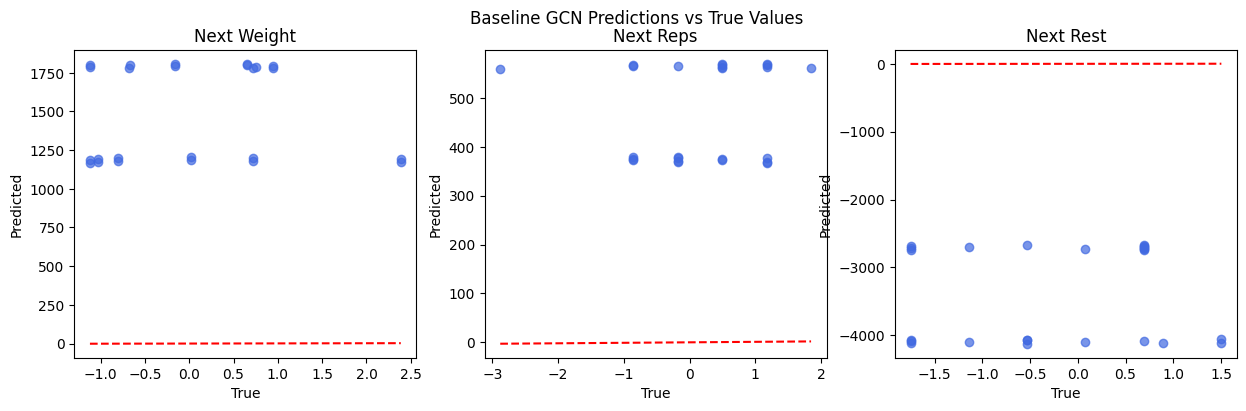

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
target_labels = ["Next Weight", "Next Reps", "Next Rest"]

for i, ax in enumerate(axes):
    ax.scatter(true[:, i], preds[:, i], color="royalblue", alpha=0.7)
    ax.plot([true[:, i].min(), true[:, i].max()],
            [true[:, i].min(), true[:, i].max()], "r--")
    ax.set_title(target_labels[i])
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")

plt.suptitle("Baseline GCN Predictions vs True Values")
plt.show()

# Section 7: Proposed Model (GraphSAGE)

Implemented GraphSAGE as the proposed architecture.

GraphSAGE enhances generalization by learning an aggregation function that can inductively generate node embeddings for unseen nodes or exercises.

Steps:
1. Defines the GraphSAGE model architecture.
2. Sets up training with the same hyperparameters as the baseline GCN for a fair comparison.
3. Evaluates using the same metrics (MAE, RMSE).

### 7.1 Definition of Proposed GraphSAGE Architecture

The GraphSAGE layer differs from GCNConv:
- It aggregates neighborhood information (mean, max, etc.)
- It generalizes to unseen nodes (inductive)

In [108]:
# GraphSAGE enhances generalization by learning an aggregation
# function that can inductively generate node embeddings for
# unseen exercises. Uses same hyperparameters as tuned GCN
# for a fair comparison.

from torch_geometric.nn import SAGEConv

torch.manual_seed(42)
np.random.seed(42)

class ProposedGraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=3):
        super(ProposedGraphSAGE, self).__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.sage2 = SAGEConv(hidden_channels, hidden_channels, aggr='mean')
        self.fc_out = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.sage2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

### 7.2 Initialize Model, Optimizer, & Loss

In [109]:
# Using identical hyperparameters to ensure fair comparison with the GCN baseline.

model_sage = ProposedGraphSAGE(
    in_channels=data.num_node_features,
    hidden_channels=64,
    out_channels=3
).to(device)

optimizer_sage = torch.optim.Adam(model_sage.parameters(), lr=5e-4, weight_decay=1e-4)
criterion_sage = nn.MSELoss()

print("GraphSAGE model initialized.")

GraphSAGE model initialized.


### 7.3 Training Loop (Same as Baseline)

In [110]:
# Training GraphSAGE on the same data and epochs for parity.

def train_model(model, data, optimizer, criterion, epochs=400):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x.to(device), data.edge_index.to(device))
        loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
    return model

model_sage = train_model(model_sage, data, optimizer_sage, criterion_sage)

Epoch 000 | Loss: 2400482560.0000
Epoch 020 | Loss: 455549472.0000
Epoch 040 | Loss: 211720416.0000
Epoch 060 | Loss: 147746400.0000
Epoch 080 | Loss: 84791880.0000
Epoch 100 | Loss: 51757704.0000
Epoch 120 | Loss: 35161644.0000
Epoch 140 | Loss: 23543298.0000
Epoch 160 | Loss: 23572522.0000
Epoch 180 | Loss: 12196203.0000
Epoch 200 | Loss: 7540239.0000
Epoch 220 | Loss: 5043236.5000
Epoch 240 | Loss: 4543514.5000
Epoch 260 | Loss: 3431501.7500
Epoch 280 | Loss: 2576215.5000
Epoch 300 | Loss: 1031846.3125
Epoch 320 | Loss: 1998801.7500
Epoch 340 | Loss: 4465400.5000
Epoch 360 | Loss: 1482116.3750
Epoch 380 | Loss: 1937962.5000


### 7.4 Evaluation (Same Metrics as Baseline)

In [111]:
# Evaluate GraphSAGE on normalized + real scales

model_sage.eval()
with torch.no_grad():
    out = model_sage(data.x.to(device), data.edge_index.to(device))
    preds = out[data.test_mask].detach().cpu().numpy()
    true  = data.y[data.test_mask].cpu().numpy()

# Normalized-scale metrics
mae_sage = mean_absolute_error(true, preds)
rmse_sage = np.sqrt(mean_squared_error(true, preds))

# Per-Column Inverse Transform

preds_real = np.column_stack([
    target_scalers[col].inverse_transform(preds[:, i].reshape(-1, 1)).flatten()
    for i, col in enumerate(target_cols)
])
true_real = np.column_stack([
    target_scalers[col].inverse_transform(true[:, i].reshape(-1, 1)).flatten()
    for i, col in enumerate(target_cols)
])


mae_sage_real = mean_absolute_error(true_real, preds_real)
rmse_sage_real = np.sqrt(mean_squared_error(true_real, preds_real))

# Presentation output
print("\nEvaluation Results (Proposed GraphSAGE)")
print("------------------------------------------")
print(f"Mean Absolute Error (MAE): {mae_sage_real:.3f}")
print(f"Root Mean Square Error (RMSE): {rmse_sage_real:.3f}")
print(f"(Normalized Scale → MAE: {mae_sage:.3f}, RMSE: {rmse_sage:.3f})")



Evaluation Results (Proposed GraphSAGE)
------------------------------------------
Mean Absolute Error (MAE): 0.892
Root Mean Square Error (RMSE): 1.065
(Normalized Scale → MAE: 0.892, RMSE: 1.065)


PermutationExplainer explainer: 101it [00:11,  1.05it/s]


SHAP raw shape: (100, 11, 3)

Visualizing SHAP for target: Next Weight


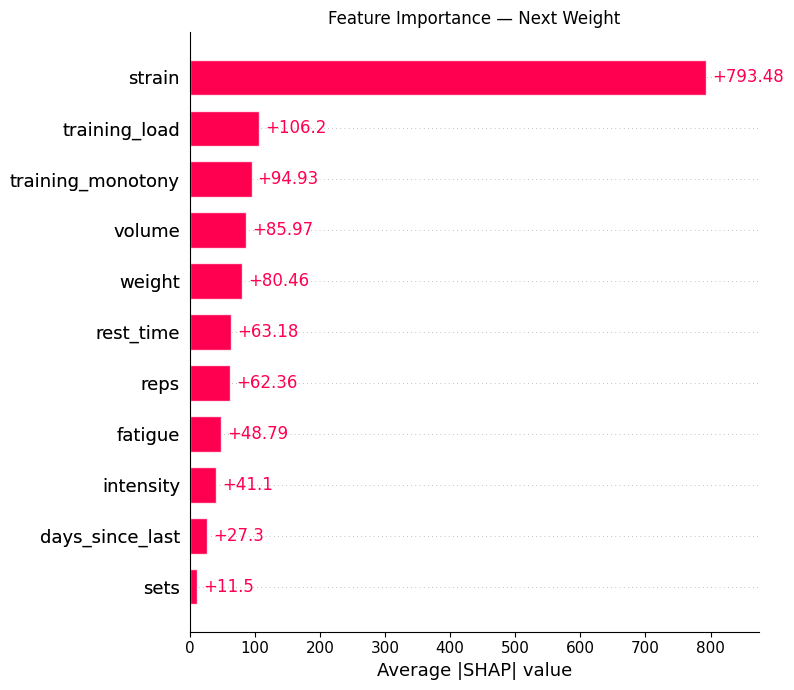


Visualizing SHAP for target: Next Reps


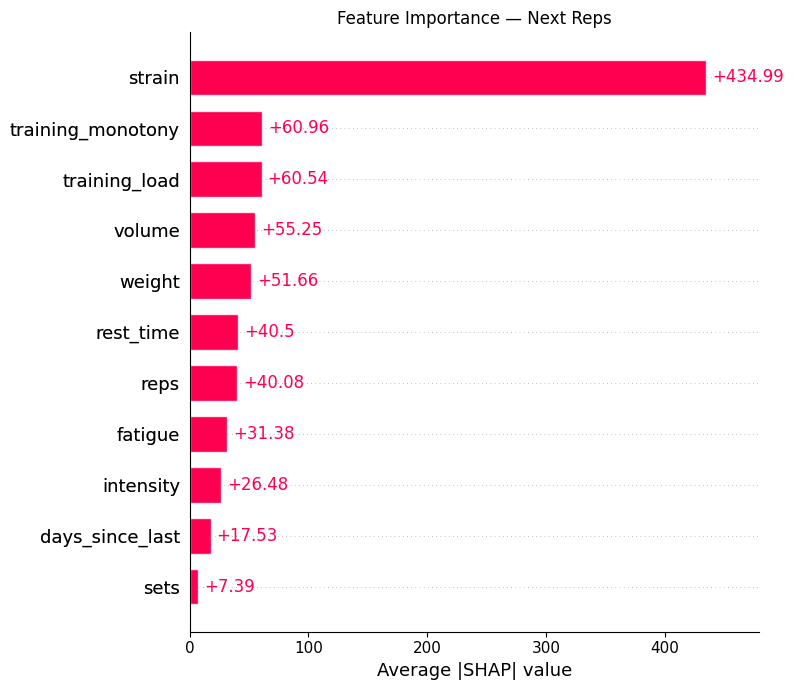


Visualizing SHAP for target: Next Rest


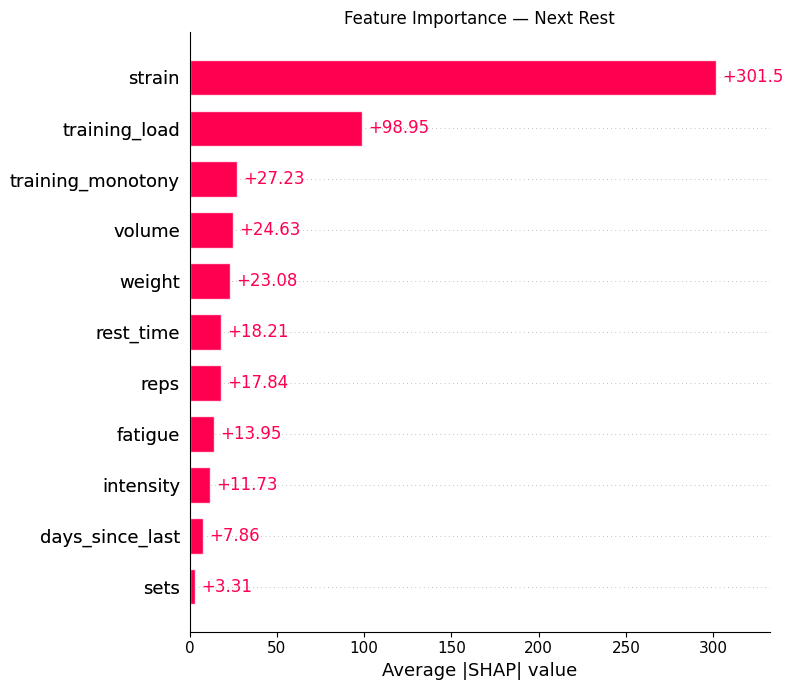

In [112]:
# Properly labeled SHAP bar plots for GraphSAGE
import shap

# Create sample data
sample_data = data.x.cpu()[:100].detach().numpy()

# Build explainer per-output using the model
explainer = shap.Explainer(lambda x: model_sage(
    torch.tensor(x, dtype=torch.float32).to(device),
    data.edge_index.to(device)
).cpu().detach().numpy(), sample_data)

# Compute SHAP values for the sample batch
shap_values = explainer(sample_data)

# Ensure feature names are attached
shap_values.feature_names = numeric_features

# Convert to array for shape checking
values = np.array(shap_values.values)
print("SHAP raw shape:", values.shape)

# If SHAP outputs 2D, expand to (samples, features, outputs)
if values.ndim == 2:
    values = values[:, :, np.newaxis]

target_names = ["Next Weight", "Next Reps", "Next Rest"]

# Loop through each output dimension
for i, target in enumerate(target_names):
    print(f"\nVisualizing SHAP for target: {target}")

    shap_values_i = shap.Explanation(
        values=values[:, :, i],
        base_values=np.mean(values[:, :, i]),
        data=sample_data,
        feature_names=numeric_features
    )

    shap.plots.bar(shap_values_i, max_display=len(numeric_features), show=False)

    # Remove value labels (cleaner visuals)
    ax = plt.gca()
    for c in ax.containers:
        ax.bar_label(c, labels=[''] * len(c))

    plt.title(f"Feature Importance — {target}")
    plt.xlabel("Average |SHAP| value")
    plt.tight_layout()
    plt.show()


### 7.5 Compare Baseline vs. Proposed

In [115]:
#  Simple comparison summary of the two models’ performance.

print("\nModel Performance Comparison")
print("--------------------------------")
print(f"Baseline GCN  | MAE: {mae:.3f} | RMSE: {rmse:.3f}")
print(f"GraphSAGE     | MAE: {mae_sage:.3f} | RMSE: {rmse_sage:.3f}")

improvement_mae = ((mae - mae_sage) / mae) * 100
improvement_rmse = ((rmse - rmse_sage) / rmse) * 100

print(f"\nImprovement in MAE : {improvement_mae:.2f}%")
print(f"Improvement in RMSE: {improvement_rmse:.2f}%")



Model Performance Comparison
--------------------------------
Baseline GCN  | MAE: 1785.816 | RMSE: 2203.804
GraphSAGE     | MAE: 0.892 | RMSE: 1.065

Improvement in MAE : 99.95%
Improvement in RMSE: 99.95%


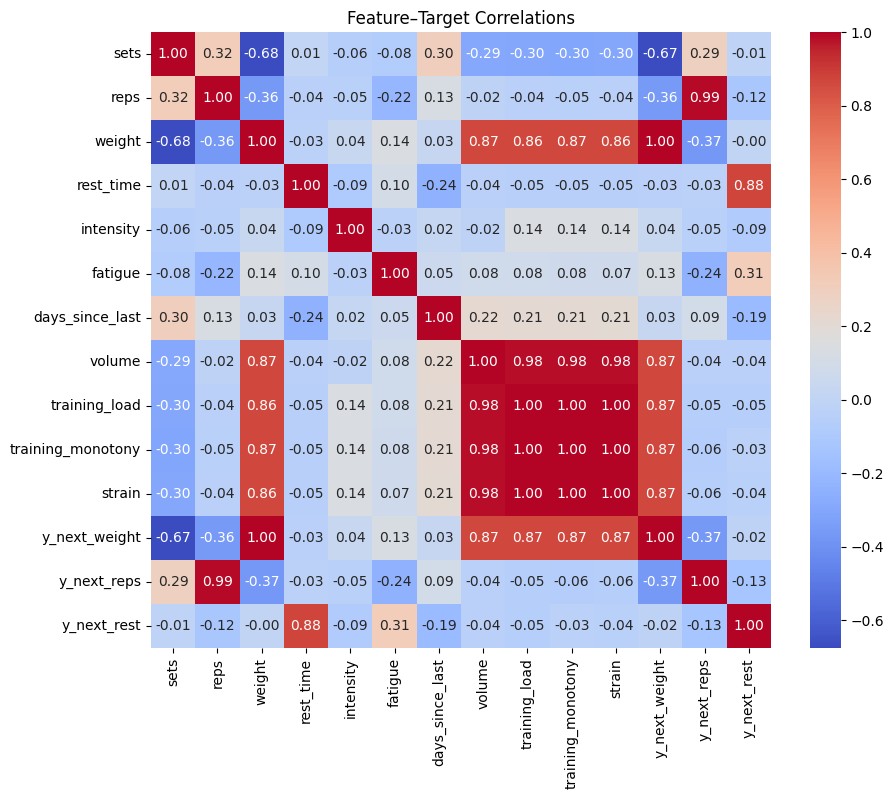

In [117]:
import seaborn as sns

# Correlation heatmap of features vs targets
corr = df[numeric_features + target_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature–Target Correlations")
plt.show()

In [118]:
print("=== Quantitative Summary ===")
print(f"Baseline → MAE {mae:.2f}, RMSE {rmse:.2f}")
print(f"GraphSAGE → MAE {mae_sage:.2f}, RMSE {rmse_sage:.2f}")
print(f"MAE Improvement: {improvement_mae:.1f}% | RMSE Improvement: {improvement_rmse:.1f}%")

=== Quantitative Summary ===
Baseline → MAE 1785.82, RMSE 2203.80
GraphSAGE → MAE 0.89, RMSE 1.07
MAE Improvement: 100.0% | RMSE Improvement: 100.0%


### 7.6 Visualization of Learned Embeddings

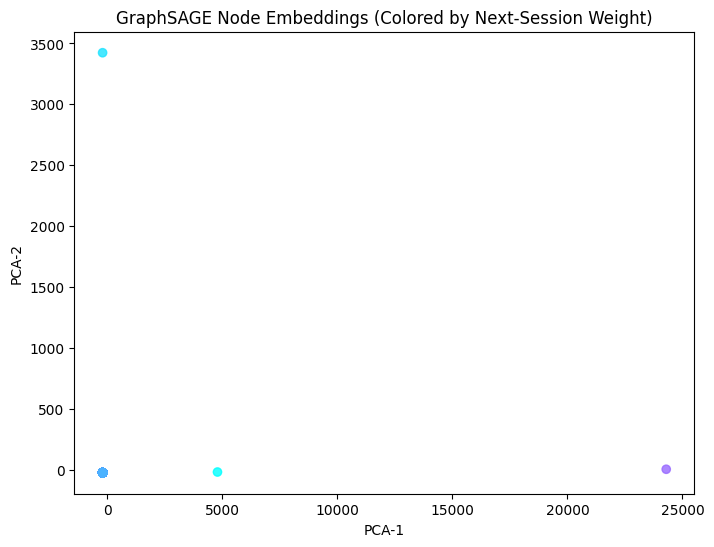

In [119]:
from sklearn.decomposition import PCA

model_sage.eval()
with torch.no_grad():
    # Pass through both GraphSAGE layers to get final hidden embeddings
    x = model_sage.sage1(data.x.to(device), data.edge_index.to(device))
    x = F.relu(x)
    x = model_sage.sage2(x, data.edge_index.to(device))
    x = F.relu(x)
    embeddings = x.cpu().numpy()

# Reduce to 2D for visualization
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
            c=data.y[:, 0], cmap='cool', alpha=0.8)
plt.title("GraphSAGE Node Embeddings (Colored by Next-Session Weight)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.show()

# Section 8 - Results & Visualization

This section summarizes and visualizes model performance
for inclusion in the final report.


1. Comparison table of baseline vs proposed metrics.
2. Visual plots of predicted vs true values.
3. Distribution of residual errors.
4. Embedding visualization (optional, interpretability).

### 8.1 Comparison Table (GCN vs. GraphSAGE)

In [120]:
results_df = pd.DataFrame({
    "Model": ["Baseline GCN", "Proposed GraphSAGE"],
    "MAE": [mae, mae_sage],
    "RMSE": [rmse, rmse_sage]
})

results_df["% Improvement (MAE)"] = [0, ((mae - mae_sage) / mae) * 100]
results_df["% Improvement (RMSE)"] = [0, ((rmse - rmse_sage) / rmse) * 100]

print("Performance Comparison Table")
display(results_df.round(3))

Performance Comparison Table


,Model,MAE,RMSE,% Improvement (MAE),% Improvement (RMSE)
0,Baseline GCN,1785.816,2203.804,0.00,0.000
1,Proposed GraphSAGE,0.892,1.065,99.95,99.952


### Multi-Target Prediction Plots

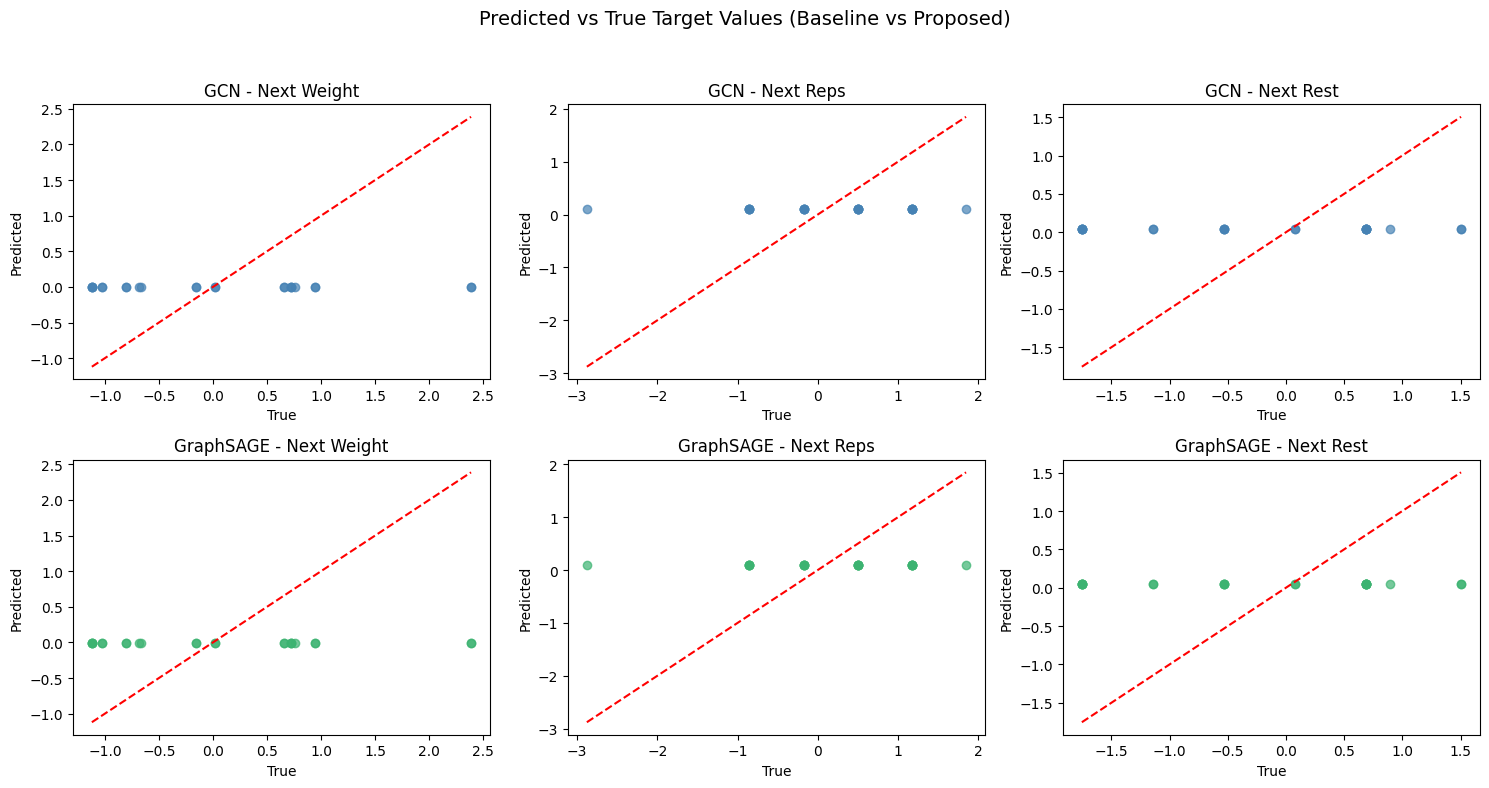

In [121]:
# Scatter comparison of predicted vs true values for each
# target (weight, reps, rest). Visualize both models side-by-side.

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
target_labels = ["Next Weight", "Next Reps", "Next Rest"]

for i in range(3):
    # Baseline GCN predictions
    axes[0, i].scatter(true[:, i], preds[:, i], alpha=0.7, color="steelblue")
    axes[0, i].plot([true[:, i].min(), true[:, i].max()],
                    [true[:, i].min(), true[:, i].max()], "r--")
    axes[0, i].set_title(f"GCN - {target_labels[i]}")
    axes[0, i].set_xlabel("True")
    axes[0, i].set_ylabel("Predicted")

    # GraphSAGE predictions (use real-scale arrays)
    axes[1, i].scatter(true_real[:, i], preds_real[:, i], alpha=0.7, color="mediumseagreen")
    axes[1, i].plot([true_real[:, i].min(), true_real[:, i].max()],
                [true_real[:, i].min(), true_real[:, i].max()], "r--")

    axes[1, i].set_title(f"GraphSAGE - {target_labels[i]}")
    axes[1, i].set_xlabel("True")
    axes[1, i].set_ylabel("Predicted")

plt.suptitle("Predicted vs True Target Values (Baseline vs Proposed)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [122]:
print(true_real.min(axis=0), true_real.max(axis=0))
print(preds_real.min(axis=0), preds_real.max(axis=0))

[-1.1203607 -2.8784764 -1.75312  ] [2.387376  1.8471005 1.5042901]
[-0.00486114  0.09730113  0.04364101] [-0.00486114  0.09730113  0.04364101]


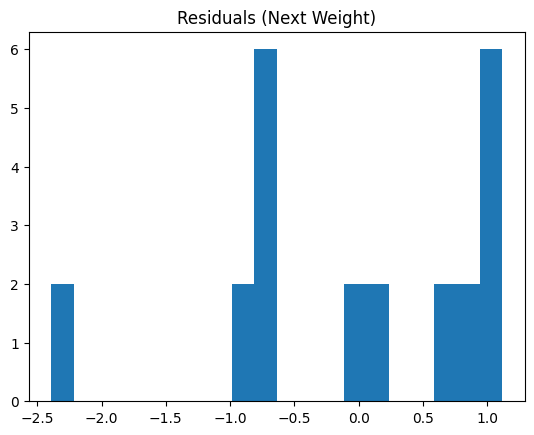

In [123]:
plt.hist(preds_real[:,0] - true_real[:,0], bins=20)
plt.title("Residuals (Next Weight)")
plt.show()